In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
import signal_model_utilities_v2 as sm2

In [3]:
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

In [4]:
def measurement_response_harmonics(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,noise_floor,no_harmonics,plot,manual):
    force_vec_scaled= force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/fs) # make a time array, default 1s
    print(fs,len(time),int_time)
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec_scaled)) # length of the array
    #noise_floor = 1.85*np.pi*1e-17
    signal = osci_force_func(stroke,time,frequency,pos_vec,force_vec_scaled)
    print(length)
    print(time)
    noise = noise_floor  * np.random.randn(length)
    background = 0 # implement later
    measurement = noise + signal + background
    print(np.mean(measurement))
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(measurement)) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(length,fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(measurement, 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    print(len(psd_dat2))
    response = []
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,np.max(no_harmonics)*frequency)
        plt.show()
    for i in no_harmonics:
        if(manual==True):
            response.append(psd_dat1[i*frequency])
        if(manual==False):    
            response.append(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [20]:
def alpha_response(alpha):
    no_harmonics = [6]
    noise_floor =  0
    frequency = 3
    stroke = 500e-6
    fs = 5000
    int_time=1
    response_list=[]
    for k in np.arange(0,100,1):
        response_list.append(measurement_response_harmonics(alpha=alpha,int_time=int_time,fs=fs,pos_vec=pos_vec*1e-6,force_vec=force_vec,stroke=stroke,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
    signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
    return np.mean(signal_resp_per_harmonic)

In [21]:
num_cores = 24


In [22]:
alpha_list=[]
lambda_list=[]

x_sep = 3.8+1.5
height_sep = 0
  

for lambda_yuk in tqdm(np.geomspace(1,1e3,10)):
    pos_vec,force_vec = sm2.force_vs_position(x_sep=x_sep,height_sep=height_sep,lambda_val=lambda_yuk,axis="X",yuk_or_grav="yuk",bead_size=7.6,posvec=np.linspace(-249.5, 249.0, 501))
    alpha_list=np.geomspace(1e2,1e12,300)
    alpha_result = Parallel(n_jobs=num_cores)(delayed(alpha_response)(alpha) for alpha in alpha_list)
    #print(alpha_result)
    lambda_list.append(alpha_list[next(x[0] for x in enumerate(alpha_result) if x[1] > 1.2e-20)])
    

    


  0%|          | 0/10 [00:00<?, ?it/s]

Loading Gravity Data... Done!
90 1e-06
Loaded Yukawa Force


 10%|█         | 1/10 [00:02<00:21,  2.40s/it]

Loading Gravity Data... Done!
80 2.15443469003e-06
Loaded Yukawa Force


 20%|██        | 2/10 [00:04<00:19,  2.42s/it]

Loading Gravity Data... Done!
70 4.64158883361e-06
Loaded Yukawa Force


 30%|███       | 3/10 [00:07<00:17,  2.47s/it]

Loading Gravity Data... Done!
60 1e-05
Loaded Yukawa Force


 40%|████      | 4/10 [00:09<00:14,  2.45s/it]

Loading Gravity Data... Done!
50 2.15443469003e-05
Loaded Yukawa Force


 50%|█████     | 5/10 [00:12<00:12,  2.44s/it]

Loading Gravity Data... Done!
40 4.64158883361e-05
Loaded Yukawa Force


 60%|██████    | 6/10 [00:14<00:09,  2.49s/it]

Loading Gravity Data... Done!
30 0.0001
Loaded Yukawa Force


 70%|███████   | 7/10 [00:17<00:07,  2.47s/it]

Loading Gravity Data... Done!
20 0.000215443469003
Loaded Yukawa Force


 80%|████████  | 8/10 [00:20<00:05,  2.59s/it]

Loading Gravity Data... Done!
10 0.000464158883361
Loaded Yukawa Force


 90%|█████████ | 9/10 [00:22<00:02,  2.54s/it]

Loading Gravity Data... Done!
0 0.001
Loaded Yukawa Force


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


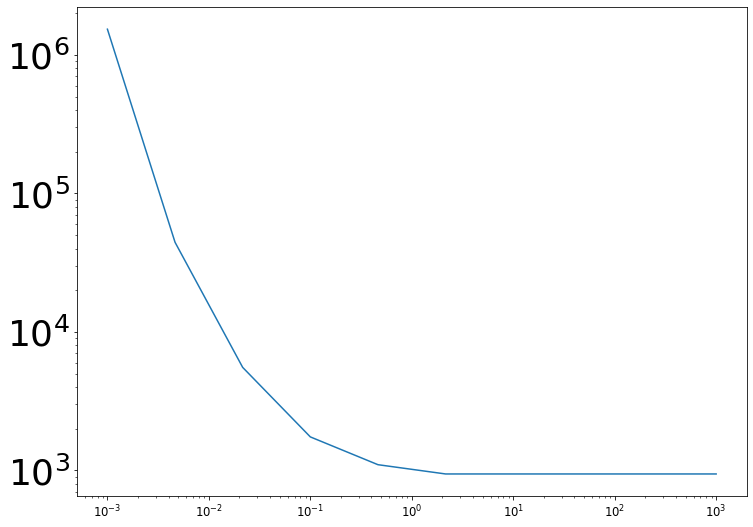

In [23]:
plt.loglog(np.geomspace(1e-3,1e3,10),lambda_list/np.sqrt(1000))